<div style="text-align: center; font-size: 25pt; font-weight: bold; margin: 1em 0em 1em 0em">Usages of the MCN package</div>

**Author:** Adel Nabli

# Introduction: The Multilevel Critical Node problem

We have a graph $G(V,E)$ and we want to solve a multilevel critical node problem as introduced in [1]. We use the following variables:
* $D \subset V$: set of vaccinated nodes $\quad ; \quad$ $z_v = \mathbb{1}_{\text{v is vaccinated}}$ $\quad ; \quad$ $\sum_{v \in V} z_v \leq \Omega$
* $P \subset V$: set of protected nodes $\quad ; \quad$ $x_v = \mathbb{1}_{\text{v is protected}}$ $\quad ; \quad$ $\sum_{v \in V} x_v \leq \Lambda$
* $I \subset V$: set of attacked nodes $\quad ; \quad$ $y_v = \mathbb{1}_{\text{v is attacked}}$ $\quad ; \quad$ $\sum_{v \in V} y_v \leq \Phi$
* $S \subset V$: set of saved nodes $\quad ; \quad$ $\alpha_v = \mathbb{1}_{\text{v is saved}}$

We want to solve the following trilevel problem:
<h3 align="center"> $ \underset{ \substack{z \in \{0,1\}^V \\ \sum_{v \in V} z_v \leq \Omega}}{\max} \underset{ \substack{y \in \{0,1\}^V \\ \sum_{v \in V} y_v \leq \Phi}}{\min} \underset{ \substack{x \in \{0,1\}^V \\ \alpha \in [0,1]^V}}{\max} \sum_{v \in V} \alpha_v  \\ \quad \quad  \quad \quad \text{subject to} \quad \sum_{v \in V} x_v \leq \Lambda \\ \quad  \quad \quad  \quad \quad \quad \quad \quad \quad \alpha_v \leq 1+ z_v - y_v \quad \forall v \in V \\ \quad  \quad \quad  \quad \quad \quad \quad \quad \quad \alpha_v \leq \alpha_u + x_v + z_v \quad \forall (u,v) \in E$</h3>

**Sources:**

[1] **A. Baggio, M. Carvalho, A. Lodi, A. Tramontani**, ["Multilevel Approaches for the Critical Node Problem"]( http://cerc-datascience.polymtl.ca/wp-content/uploads/2017/11/Technical-Report_DS4DM-2017-012.pdf), 2018.

# [OPTIONAL] Google colab: installing packages

If this notebook is to be run on google colab, some extra steps should be taken to properly install pytorch geometric.
Replace ```${CUDA}``` and ```${TORCH}``` with the versions on the PyTorch installation you use as explained in the [pytorch geometric documentation](https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html)

In [ ]:
!pip install torch-scatter==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-sparse==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-cluster==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-spline-conv==latest+${CUDA} -f https://pytorch-geometric.com/whl/torch-${TORCH}.html
!pip install torch-geometric
!pip install --upgrade git+https://github.com/AdelNabli/MCN

# 1. Training the neural network to solve the MCN

In [ ]:
# Import the training function
from MCN.MCN_heur.train_cur import train_value_net
import os

### a) setting the variables governing the distribution of instances

As described in our paper, we considered two distributions of instances $\mathbb{D}^{(1)}$ and $\mathbb{D}^{(2)}$ in our experiments. In this notebook, we provide the settings for $\mathbb{D}^{(1)}$. Moreover, we will consider the *basic* case, i.e., our graphs will be unitary and undirected.

In [2]:
# n_free designs the number of nodes of the graph
# that would be neither vaccinated, infected or attacked.
# It governs the range of graph's sizes we are considering
n_free_min = 9
n_free_max = 14
# d_edge controls the density of edge we want the instances
# to have. d_edge = 1. means that all possible edges are created
# i.e, we have a clique
d_edge_min = 0.1
d_edge_max = 0.2
# Omega, Phi and Lambda are the budgets of the players
# Phi_max should be >= 1, otherwise there is no MCN problem
Omega_max = 3
Phi_max = 3
Lambda_max = 3
# n_max is the size of largest graph possible to encounter in the distribution of instances
n_max = n_free_max + Omega_max + Phi_max + Lambda_max
# weighted and directed are two boleans governing
# whether or not we work on weighted or directed graphs.
weighted = False
directed = False
# if weighted, we need to cap the maximum weights considered w_max.
# the weights of the nodes will then be integers in [1, w_max]
w_max = 5

### b) setting the hyperparameters of the neural network

In [3]:
# parameters of the neural networks used
dim_embedding = 200
dim_values = 100
dim_hidden = 400
# the number of attention heads in the GAT
n_heads = 3
# the number of attention layer used to create the node representations
n_att_layers = 7
# the number of different pooling stacked to create the graph embedding
n_pool = 3
# the dropout probability
p = 0.2
# the 'skip connection' parameter in the APPNP part
alpha = 0.2

# parameters of the optimizer used
lr = 1.3e-4
betas = (0.8, 0.98)

### c) setting the parameters of the training algorithm

In [4]:
# batch size used
batch_size = 256
# Size of each training set
size_train_data = 50000
# Size of each validation set
size_val_data = 1000
# Size of each test set
size_test_data = 1000
# number of epochs at each stage of the curriculum
n_epoch = 60
# whether or not to use an exact algorithm
# to solve protection problems
exact_protection = False
# the number of optimization steps before
# checking on the validation set
update_experts = 20
# the size of the batch when generating the training sets
batch_unroll = 128
# path where to find the test_data.
# If the path is None, a test set is generated, which necessitates cplex.
folder_name = 'test_data'
path_test_data = os.path.join('data', folder_name)
# path to the directory to pre-trained target nets
path_experts = None
# path to the directory containing the training and validation data
# to use if re-start the training
path_data = 'data'
# If resume training, set to True
resume_training = False
# path to the file containing the training parameters to load
path_train = "" #"models/value_net.tar"

In [ ]:
# Train the neural network
train_value_net(batch_size, size_train_data, size_val_data, size_test_data, lr, betas, n_epoch, update_experts,
                dim_embedding, dim_values, dim_hidden, n_heads, n_att_layers, n_pool, alpha, p,
                n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                weighted=weighted, w_max=w_max, directed=directed, path_experts=path_experts, path_data=path_data,
                resume_training=resume_training, path_train=path_train,
                path_test_data=path_test_data, exact_protection=exact_protection, batch_unroll=batch_unroll)

# 2. Using trained experts or an exact algorithm to solve an instance of MCN

### a) Generating a random instance

In [5]:
# import the function generating a random instance
from MCN.utils import generate_random_instance, plot_graph

L:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


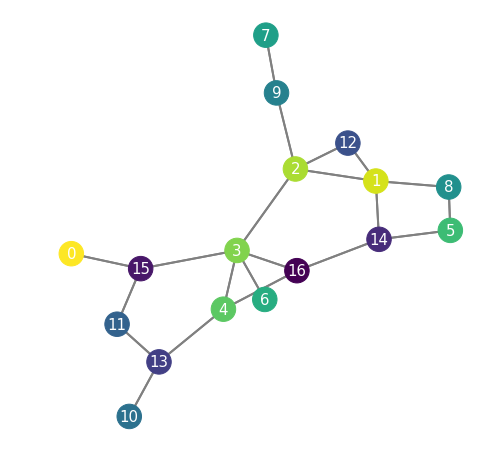

Already attacked nodes :  []
Omega : 2 ,  Phi : 2 , Lambda : 3


In [14]:
instance = generate_random_instance(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                                   directed=directed, weighted=weighted)
G = instance.G
Omega = instance.Omega
Phi = instance.Phi
Lambda = instance.Lambda
J = instance.J
# plots the graph
plot_graph(G)
# print the other parameters
print("Already attacked nodes : ", J)
print("Omega : %d ,  Phi : %d , Lambda : %d"%(Omega, Phi, Lambda))

### b) Solving the instance exactly

In [6]:
# import the solver
from MCN.solve_mcn import solve_mcn

In [16]:
value, D, I, P = solve_mcn(G, Omega, Phi, Lambda, J=J, exact=True)
# print the outputs
print("Values of the saved nodes : ", value)
print("Vaccinated nodes D: ", D)
print("Attacked nodes I : ", I)
print("Protected nodes P :", P)

Values of the saved nodes :  13
Vaccinated nodes D:  [1, 3]
Attacked nodes I :  [5, 13]
Protected nodes P : [4, 11, 14]


### c) Displaying the real value of each node

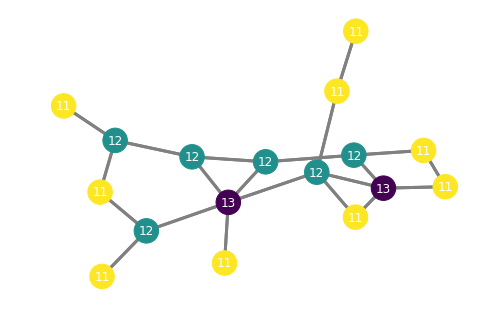

In [17]:
from MCN.test_performances.experiments import compute_node_values

compute_node_values(G, J, Omega, Phi, Lambda, exact=True)

### d) Solving the instance heuristically with pre-trained experts

In [7]:
# import the ValueNet object
from MCN.MCN_heur.neural_networks import ValueNet
# import the experts loader
from MCN.utils import load_saved_experts

In [9]:
# load the models
list_experts = load_saved_experts("models/trained_on_D1/experts", dim_input=5, dim_embedding=dim_embedding,
                                  dim_values=dim_values, dim_hidden=dim_hidden, n_heads=n_heads, n_att_layers=n_att_layers,
                                  n_pool=n_pool, K=n_max, alpha=alpha, p=p, weighted=weighted)

In [20]:
value, D, I, P = solve_mcn(G, Omega, Phi, Lambda, J=J,
                           Omega_max=Omega_max, Phi_max=Phi_max, Lambda_max=Lambda_max,
                           exact=False, list_experts=list_experts)
# print the outputs
print("Values of the saved nodes : ", value)
print("Vaccinated nodes D: ", D)
print("Attacked nodes I : ", I)
print("Protected nodes P :", P)

Values of the saved nodes :  13.0
Vaccinated nodes D:  [3, 1]
Attacked nodes I :  [9, 13]
Protected nodes P : [4, 11, 2]


### e) Displaying the approximate value of each node

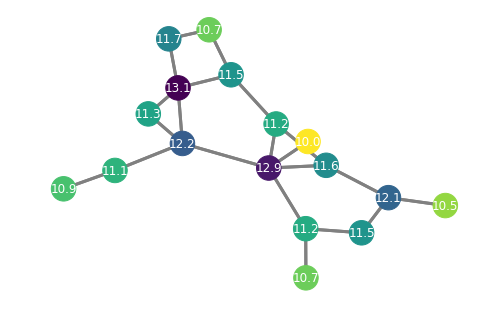

In [21]:
compute_node_values(G, J, Omega, Phi, Lambda, exact=False, Omega_max=Omega_max, Phi_max=Phi_max, Lambda_max=Lambda_max,
                    list_experts=list_experts)

# 3. Test the performances of the heuristic

### a) Generate a test set for each stage of the curriculum

In [10]:
# import the generator
from MCN.MCN_heur.data import generate_test_set

In [11]:
# create a test set named "test_set.gz" in the directory given (creates it if not existing)
# the argument 'size_test_set' indicate the size of each of the test sets for the stages of the curriculum
generate_test_set(n_free_min, n_free_max, d_edge_min, d_edge_max, Omega_max, Phi_max, Lambda_max,
                  weighted, w_max, directed, size_test_set=1000)

Generates the test set... 



100%|████████████████████████████████████████████████████████████████████████████████| 9/9 [3:08:51<00:00, 2400.11s/it]


### b) Compute the optimality gap and approximation ratio of the heuristic

Formula applied to compute the optimality gap:
<h3 align="center"> $ \eta = \frac{1}{n_{instance}} \sum_{i=1}^{n_{instance}}\frac{|value_i^{(true)} - value_i^{(heur)}|}{ value_i^{(true)}}$</h3>
Formula applied to compute the approximation ratio:
<h3 align="center"> $\zeta = \frac{1}{n_{instance}} \sum_{i=1}^{n_{instance}} \max \left( \frac{value_i^{(true)}}{ value_i^{(heur)}}, \frac{value_i^{(heur)}}{ value_i^{(true)}} \right)$</h3>

In [12]:
# to display the dataframes
import pandas as pd
# import the fonction that tests that
from MCN.test_performances.experiments import metrics_each_stage_cur

In [13]:
df_budget, df_player, idx_budget, idx_player = metrics_each_stage_cur(Omega_max, Phi_max, Lambda_max,
                                                                       list_experts, exact_protection=False,
                                                                       path_test_data="data/test_data", DQN=False)
df_budget = pd.DataFrame(df_budget, index=idx_budget)
display(df_budget)
df_player = pd.DataFrame(df_player, index=idx_player)
display(df_player)

Computing the values using the heuristic... 



100%|█████████████████████████████████████████████████████████████████████████████████| 9/9 [1:09:54<00:00, 666.07s/it]


Average Approx Ratio :  1.005480554718974
Average optimality gap : 0.492608 %


,$\eta(\%)$,$\zeta$
"$\Omega = 0, \Phi = 0 , \Lambda = 1 $",0.000000,1.000000
"$\Omega = 0, \Phi = 0 , \Lambda = 2 $",0.000000,1.000000
"$\Omega = 0, \Phi = 0 , \Lambda = 3 $",0.012500,1.000143
"$\Omega = 0, \Phi = 1 , \Lambda \in [\![0, 3]\!]$",0.102738,1.001045
"$\Omega = 0, \Phi = 2 , \Lambda \in [\![0, 3]\!]$",0.429087,1.004291
"$\Omega = 0, \Phi = 3 , \Lambda \in [\![0, 3]\!]$",0.549524,1.005495
"$\Omega = 1, \Phi \in [\![1, 3]\!] , \Lambda \in [\![0, 3]\!] $",0.599520,1.006889
"$\Omega = 2, \Phi \in [\![1, 3]\!] , \Lambda \in [\![0, 3]\!] $",1.175457,1.013416
"$\Omega = 3, \Phi \in [\![1, 3]\!] , \Lambda \in [\![0, 3]\!] $",1.072041,1.012565


,$\eta(\%)$,$\zeta$
Vaccinator,0.949006,1.010957
Attacker,0.360450,1.003610
Protector,0.004167,1.000048


### c) Compute the metrics on a publicaly available test set

We compare the results of our heuristics on a publicaly available test set of increasingly larger instances. The test set was created for the original [*Multilevel Critical Node problem* paper]( http://cerc-datascience.polymtl.ca/wp-content/uploads/2017/11/Technical-Report_DS4DM-2017-012.pdf ) and is available at the following address: https://github.com/mxmmargarida/Critical-Node-Problem . We compare the time necessary to solve our problem with the best solver available, MCN$^{MIX}$. The results displayed here are slightly different from the ones in our paper as we use an other model to heuristicaly solve the instances.

In [14]:
from MCN.test_performances.experiments import metrics_test_set

In [15]:
# First, we load our experts trained on D^2
list_experts = load_saved_experts("models/trained_on_D2/experts", dim_input=5, dim_embedding=dim_embedding,
                                  dim_values=dim_values, dim_hidden=dim_hidden, n_heads=n_heads, n_att_layers=n_att_layers,
                                  n_pool=n_pool, K=n_max, alpha=alpha, p=p, weighted=weighted)

In [16]:
df_n = metrics_test_set('data/instances_MCN_MIX.gz', Omega_max, Phi_max, Lambda_max,
                        list_experts, path_times='data/times_MCN_MIX.gz')

df= pd.DataFrame(df_n)
df = df.set_index('$\#V$')
display(df)

Computing the values using the heuristic... 



100%|█████████████████████████████████████████████████████████████████████████████████| 5/5 [1:10:51<00:00, 735.24s/it]


,$\eta(\%)$,$\zeta$,$t_{exact}(s)$,$t_{heur}(s)$
$\#V$,,,,
20,0.476852,1.004900,28.577125,1.064094
40,5.381640,1.061389,241.469055,2.433991
60,5.524543,1.071449,405.035145,3.540778
80,8.475588,1.101945,635.668673,5.791503
100,49.453096,1.501022,847.986400,11.964125
